[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on JSON Data Extraction Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Dec 18 11:23:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [2]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.3 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("objectdetection-mt6hx").project("airplane_coco-ztfud")
version = project.version(2)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to airplane_coco-2 in paligemma:: 100%|██████████| 3086/3086 [00:00<00:00, 3367.81it/s]


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [4]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"000000348504_jpg.rf.9b3729064b0c3e7bfa2983610aa91c52.jpg","prefix":"detect airplane","suffix":"<loc0405><loc0188><loc0623><loc0974> airplane"}
{"image":"000000458649_jpg.rf.9b4d65584171f13bf972be7ec04f97ab.jpg","prefix":"detect airplane","suffix":"<loc0360><loc0064><loc0759><loc0924> airplane ; <loc0397><loc0000><loc0485><loc0172> airplane ; <loc0412><loc0535><loc0447><loc0602> airplane ; <loc0407><loc0497><loc0438><loc0547> airplane ; <loc0408><loc0687><loc0443><loc0759> airplane ; <loc0411><loc0597><loc0438><loc0652> airplane"}
{"image":"000000014707_jpg.rf.9b62ad509577fa98b91f5f2a5feda078.jpg","prefix":"detect airplane","suffix":"<loc0204><loc0262><loc0515><loc0980> airplane"}
{"image":"000000356362_jpg.rf.9b636ca0d9182706d04e4a3a52b8f24c.jpg","prefix":"detect airplane","suffix":"<loc0464><loc0316><loc0620><loc0755> airplane ; <loc0680><loc0789><loc0784><loc1023> airplane"}
{"image":"000000553150_jpg.rf.9b8a9049f3e4d44890d0beb51ba82f1c.jpg","prefix":"detect airplane","suff

In [5]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"000000285607_jpg.rf.3dbe8e235a5099e1660a0d92756946e9.jpg","prefix":"detect airplane","suffix":"<loc0390><loc0346><loc0440><loc0424> airplane"}
{"image":"000000436646_jpg.rf.3e2b44f80675231bf50040ce82699028.jpg","prefix":"detect airplane","suffix":"<loc0360><loc0083><loc0679><loc0991> airplane"}
{"image":"000000393656_jpg.rf.3bf84be792ddeadd7b399318f319f31c.jpg","prefix":"detect airplane","suffix":"<loc0566><loc0403><loc0674><loc0584> airplane ; <loc0576><loc0151><loc0650><loc0247> airplane ; <loc0608><loc0000><loc0846><loc0386> airplane ; <loc0609><loc0268><loc0655><loc0355> airplane"}
{"image":"000000237482_jpg.rf.3c604eeb6d8cc45164646a4ea93755a0.jpg","prefix":"detect airplane","suffix":"<loc0318><loc0184><loc0637><loc0807> airplane"}
{"image":"000000395263_jpg.rf.3eaeff7756f2453289454fe85f261e95.jpg","prefix":"detect airplane","suffix":"<loc0126><loc0113><loc0872><loc0945> airplane"}


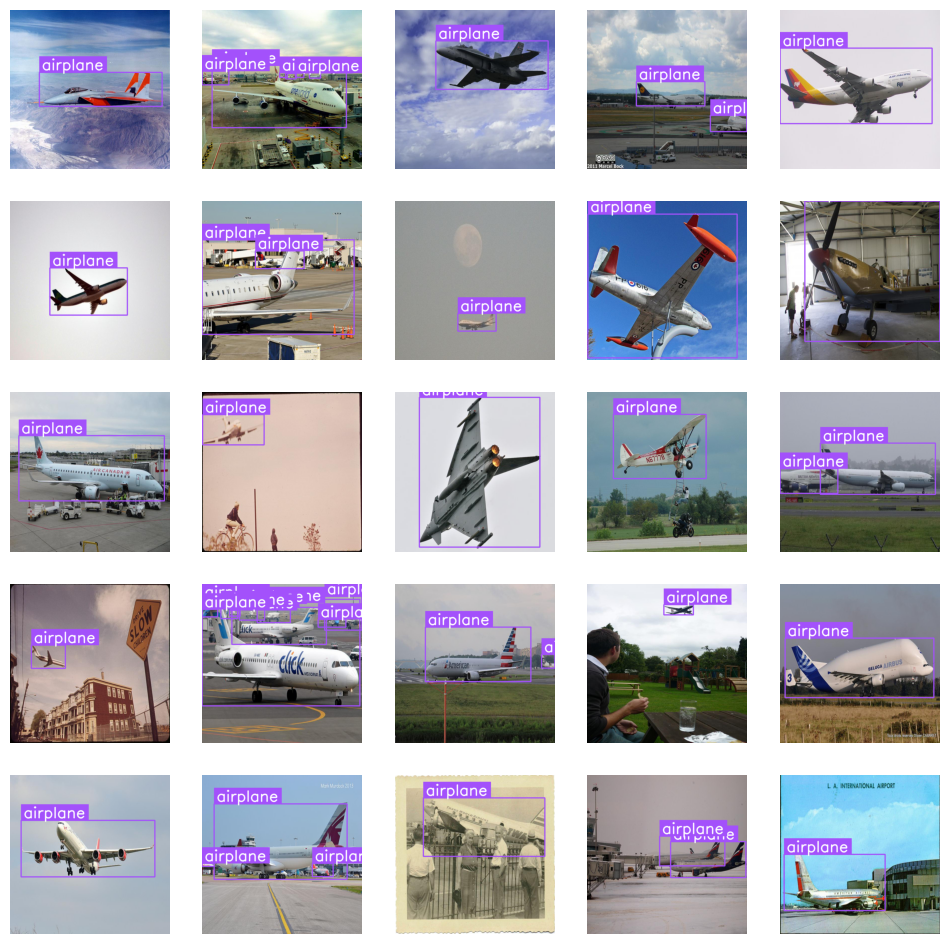

In [13]:
import cv2
import json
import supervision as sv
from typing import List

def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Set up and test data loaders

In [14]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [19]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.train.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.valid.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)


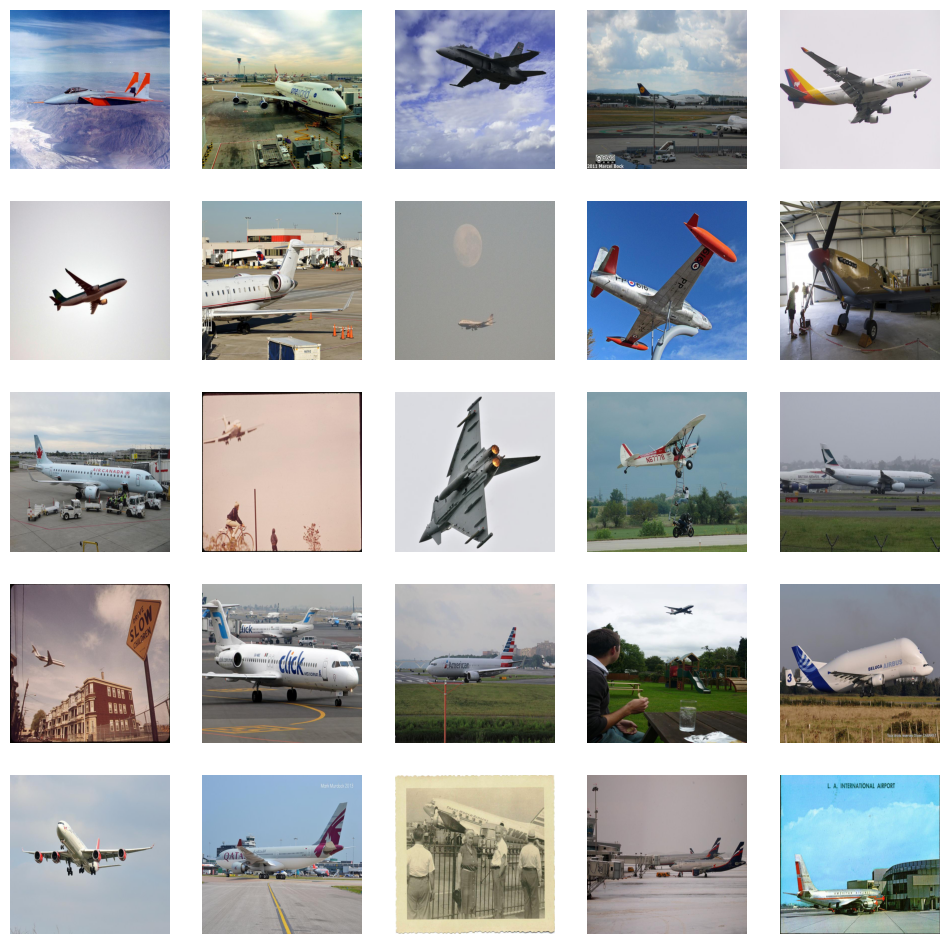

In [20]:
from tqdm import tqdm
import supervision as sv


images = []
for i in range(25):
    image, label = train_dataset[i]
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the accuracy of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [23]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/paligemma-2/transformers/paligemma2-10b-pt-448")

print("Path to model files:", path)


100%|██████████| 1.33k/1.33k [00:00<00:00, 2.94MB/s]



  0%|          | 0.00/173 [00:00<?, ?B/s]

100%|██████████| 173/173 [00:00<00:00, 124kB/s]

  0%|          | 0.00/90.5k [00:00<?, ?B/s]



  0%|          | 0.00/4.61G [00:00<?, ?B/s]




  0%|          | 0.00/4.16G [00:00<?, ?B/s]





  0%|          | 0.00/4.62G [00:00<?, ?B/s]






  0%|          | 0.00/4.61G [00:00<?, ?B/s]







100%|██████████| 425/425 [00:00<00:00, 1.22MB/s]

100%|██████████| 90.5k/90.5k [00:00<00:00, 300kB/s]


  0%|          | 1.00M/4.61G [00:01<1:45:59, 778kB/s]


  0%|          | 1.00M/4.16G [00:01<1:35:29, 779kB/s]



  0%|          | 1.00M/4.62G [00:01<1:46:13, 778kB/s]




  0%|          | 1.00M/4.61G [00:01<1:50:42, 746kB/s]

  0%|          | 2.00M/4.61G [00:01<54:27, 1.51MB/s] 


  0%|          | 2.00M/4.16G [00:01<48:43, 1.53MB/s] 



  0%|          | 2.00M/4.62G [00:01<54:31, 1.52MB/s] 

  0%|          | 3.00M/4.61G [00:01<34:12, 2.41MB/s]


  0%|          | 3.00M/4.16G [00:01<30:37, 2.43MB/s]




  0%|          | 2.00M/4.61G [00:01<56:50, 1.45MB/s] 



  0%|          | 3.00M/4.62G [00:01<34:17, 2.41MB/s]

  0%|          | 5.00M/4.61G [00:01<18:30, 4.45MB/s]




  0%|          | 3.00M/4.61G [00:01<35:46, 2.31MB/s]


  0%|          | 5.00M/4.16G [00:01<16:42, 4.44MB/s]


100%|██████████| 733/733 [00:00<00:00, 1.70MB/s]




  0%|          | 5.00M/4.62G [00:01<18:34, 4.45MB/s]

  0%|          | 7.00M/4.61G [00:01<12:06, 6.80MB/s]




  0%|          | 4.00M/4.61G [00:01<24:51, 3.32MB/s]


  0%|          | 7.00M/4.16G [00:01<10:54, 6.80MB/s]





  0%|          | 7.00M/4.62G [00:01<12:11, 6.77MB/s]
  0%|          | 0.00/33.0M [00:00<?, ?B/s]

  0%|          | 9.00M/4.61G [00:02<09:23, 8.77MB/s]




  0%|          | 6.00M/4.61G [00:02<14:19, 5.76MB/s]


  0%|          | 9.00M/4.16G [00:02<08:30, 8.72MB/s]

Streaming output truncated to the last 5000 lines.


 76%|███████▌  | 3.49G/4.62G [04:01<01:15, 16.1MB/s]




 73%|███████▎  | 3.39G/4.61G [04:01<01:22, 16.0MB/s]


 88%|████████▊ | 3.64G/4.16G [04:01<00:32, 17.2MB/s]



 76%|███████▌  | 3.50G/4.62G [04:01<01:12, 16.6MB/s]




 73%|███████▎  | 3.39G/4.61G [04:01<01:24, 15.7MB/s]

 79%|███████▉  | 3.64G/4.61G [04:01<01:00, 17.0MB/s]


 88%|████████▊ | 3.64G/4.16G [04:01<00:31, 17.6MB/s]



 76%|███████▌  | 3.50G/4.62G [04:01<01:09, 17.4MB/s]



 76%|███████▌  | 3.50G/4.62G [04:01<01:09, 17.4MB/s]


 88%|████████▊ | 3.64G/4.16G [04:02<00:32, 16.8MB/s]




 73%|███████▎  | 3.39G/4.61G [04:01<01:30, 14.5MB/s]

 79%|███████▉  | 3.65G/4.61G [04:02<01:02, 16.5MB/s]



 76%|███████▌  | 3.50G/4.62G [04:02<01:06, 18.2MB/s]


 88%|████████▊ | 3.65G/4.16G [04:02<00:32, 17.0MB/s]



 76%|███████▌  | 3.50G/4.62G [04:02<01:08, 17.6MB/s]




 74%|███████▎  | 3.39G/4.61G [04:02<01:23, 15.8MB/s]

 79%|███████▉  | 3.65G/4.61G [04:02<00:59, 17.2MB/s]


 8

Path to model files: /root/.cache/kagglehub/models/google/paligemma-2/transformers/paligemma2-10b-pt-448/1


In [22]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/paligemma2-3b-pt-448.
403 Client Error. (Request ID: Root=1-6762b56b-4758fd854c12e79f45015bb7;c99c452b-16a1-4704-b1fc-44fc9e83375f)

Cannot access gated repo for url https://huggingface.co/google/paligemma2-3b-pt-448/resolve/main/preprocessor_config.json.
Your request to access model google/paligemma2-3b-pt-448 is awaiting a review from the repo authors.

**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [ ]:
# @title Freeze the image encoder

# TORCH_DTYPE = torch.bfloat16

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

# for param in model.vision_tower.parameters():
#     param.requires_grad = False

# for param in model.multi_modal_projector.parameters():
#     param.requires_grad = False

In [ ]:
# @title Fine-tune the entire model with LoRA and QLoRA

from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

TORCH_DTYPE = model.dtype

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

trainable params: 11,876,352 || all params: 3,045,003,504 || trainable%: 0.3900


### Fine-tune PaliGemma2 on JSON data extraction dataset

In [ ]:
from transformers import Trainer, TrainingArguments


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>extract data in JSON format" for label in labels]
    suffixes = [label["suffix"] for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=20,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=50,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="paligemma2_object_detection",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [ ]:
trainer.train()

Step,Training Loss
50,0.417200
100,0.108500
150,0.068800
200,0.054900
250,0.046200
300,0.040100
350,0.034600


TrainOutput(global_step=360, training_loss=0.10800143687261475, metrics={'train_runtime': 1256.141, 'train_samples_per_second': 2.388, 'train_steps_per_second': 0.287, 'total_flos': 5.903827522465939e+16, 'train_loss': 0.10800143687261475, 'epoch': 18.96})

### Run inference with fine-tuned PaliGemma2 model

{
    "route": "V183-RZ-924",
    "pallet_number": "14",
    "delivery_date": "5/3/2024",
    "load": "4",
    "dock": "D20",
    "shipment_id": "P248127349096",
    "destination": "706 Meghan Brooks, Amyberg, IA 67863",
    "asn_number": "2211190904",
    "salesman": "RYAN GREEN",
    "products": [
        {
            "description": "293847 - ROLL OF METAL WIRE",
            "cases": "16",
            "sales_units": "8",
            "layers": "4"
        },
        {
            "description": "958773 - CASE OF SPRAY MOPS",
            "cases": "16",
            "sales_units": "8",
            "layers": "3"
        },
        {
            "description": "258963 - CASE OF MULTI-SURFACE SPRAY",
            "cases": "2",
            "sales_units": "4",
            "layers": "2"
        }
    ],
    "total_cases": "34",
    "total_units": "20",
    "total_layers": "9",
    "printed_date": "12/05/2024 10:14",
    "page_number": "91"
}


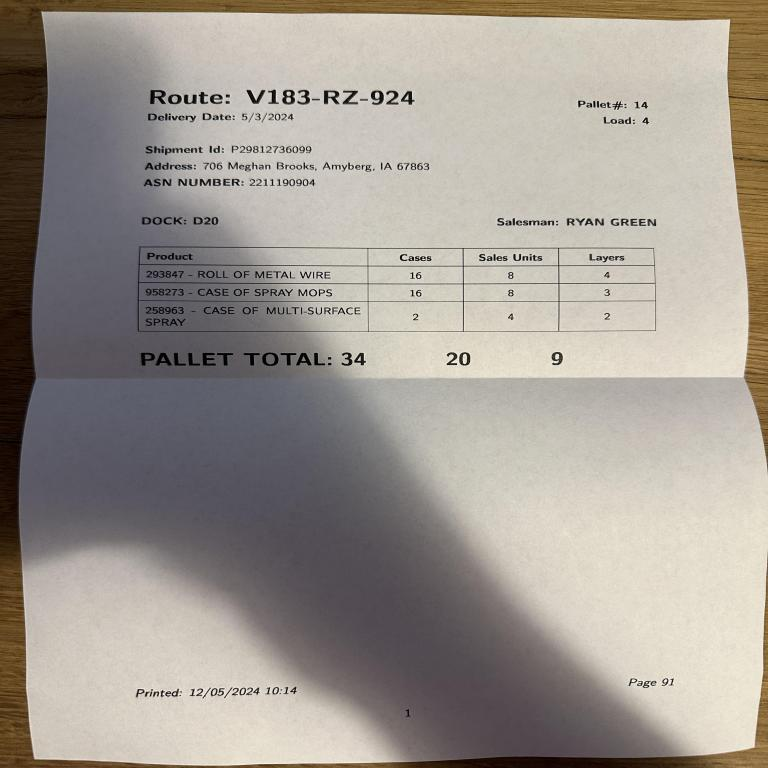

In [ ]:
image, label = test_dataset[1]
prefix = "<image>extract data in JSON format"
suffix = label["suffix"]

inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=512, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(json.dumps(json.loads(decoded), indent=4))

image

### Evaluate fine-tuned PaliGemma2 model

In [ ]:
import numpy as np

targets = []
predictions = []

with torch.inference_mode():
    for i in range(len(test_dataset)):
        image, label = test_dataset[i]
        prefix = "<image>extract data in JSON format"
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=512, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        targets.append(suffix)
        predictions.append(generated_text)

**NOTE:** BLEU (Bilingual Evaluation Understudy) is a metric used to measure the similarity between a VLM's generated text (like a caption for an image) and a human-written reference text. It works by calculating the overlap of words and phrases, giving a score between 0 and 1.  A higher BLEU score indicates better agreement between the generated text and the reference, meaning the VLM is doing a better job of producing expected output.

In [ ]:
!pip install -q evaluate

In [ ]:
# @title Calculate BLEU

from evaluate import load

bleu = load("bleu")

results = bleu.compute(predictions=predictions, references=targets)
print(results)

{'bleu': 0.9697855628127465, 'precisions': [0.987503809814081, 0.9755426475084072, 0.9638147807421037, 0.9526299600123039], 'brevity_penalty': 1.0, 'length_ratio': 1.0003048780487804, 'translation_length': 3281, 'reference_length': 3280}


In [ ]:
!pip install -q sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.3 MB/s eta 0:00:00


**NOTE:** Translation Error Rate (TER) is another metric used to evaluate machine translation, often applied to VLMs that generate text. Unlike BLEU, which focuses on overlap, TER calculates the number of edits (insertions, deletions, substitutions, shifts) needed to change the generated text into a human-written reference.

In [ ]:
# @title Calculate TER

from evaluate import load

ter = load("ter")
results = ter.compute(predictions=predictions, references=targets, case_sensitive=True)
print(results)

{'score': 6.493506493506493, 'num_edits': 40, 'ref_length': 616.0}
